In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import json
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight') 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from dateutil import parser as date_parser
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
mydate_parser = lambda x : date_parser.parse(x)

In [3]:
def read_json_file_to_df(filename):
    data = json.load(open(filename))
    df = pd.DataFrame.from_records(data['data']['candles'], columns = ['date','open','high','low','close','volume','NA'])
    df['date'] = df['date'].apply(mydate_parser)
    df.drop(['high','low', 'open','volume','NA'], axis = 1, inplace=True)
    return df

# Do analysis

In [4]:
#Creating a method for all the analysis at one place

In [46]:
def stock_analysis_arch(file_path):
    df_stock = read_json_file_to_df(file_path)
    df_stock['returns'] = 100*df_stock['close'].pct_change()
    df_stock.dropna(inplace=True)
    df = df_stock.copy(deep =True)
    
    #Plot the returns data
    plt.figure(figsize=(10,4))
    plt.plot(df['returns'])
    plt.ylabel('Pct Return', fontsize=16)
    plt.title('Stock Returns', fontsize=20)
    plt.show()
    df.drop('close', axis=1, inplace=True)
    # Plot pacf chart
    plt.figure(figsize=(10,8))
    plot_pacf(df['returns']**2, lags=30)
    plt.show()
    
    # Plot acf chart
    plt.figure(figsize=(10,8))
    plot_acf(df['returns']**2, lags=30)
    plt.show()
    
    #dividing the data into training and test
    df_length = len(df)
    train_length = .80 * df_length
    train = df.iloc[:6300]
    test = df.iloc[6300:]
    
    #Fitting arch 1 model
    #model = arch_model(df['returns'], p=1, q=0, vol='arch')
   # model_fit = model.fit()
    #model_fit.summary()
    
    #rolling predictions
    rolling_predictions = []
    test_size = len(test)

    for i in range(test_size):
        train = df[:-(test_size-i)]
        model = arch_model(train['returns'], p=2, q=2, o=2, rescale=False, vol='GARCH', mean='AR')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    rolling_predictions = pd.Series(rolling_predictions, index=df.index[-test_size:])
    plt.figure(figsize=(10,4))
    true, = plt.plot(df['returns'][-test_size:])
    preds, = plt.plot(rolling_predictions)
    plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
    plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
    plt.show()
    return np.array(df['returns'][-test_size:]), np.array(rolling_predictions)
    

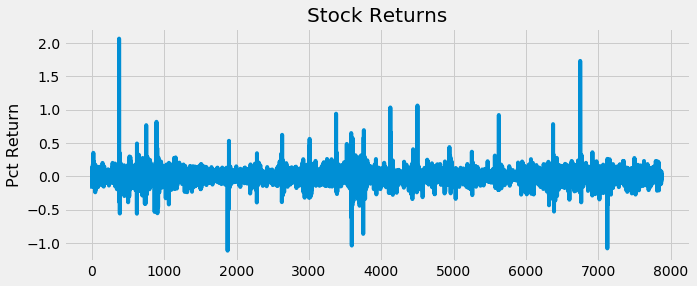

<Figure size 720x576 with 0 Axes>

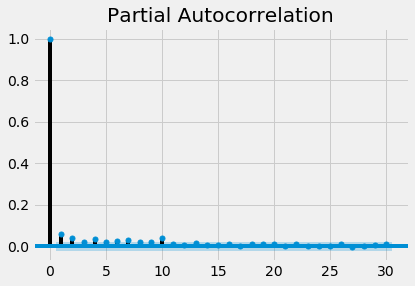

<Figure size 720x576 with 0 Axes>

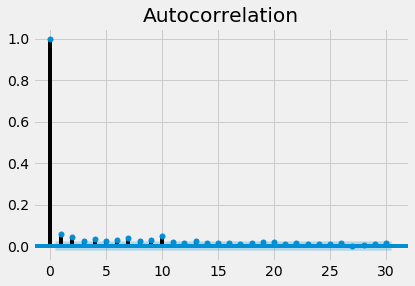

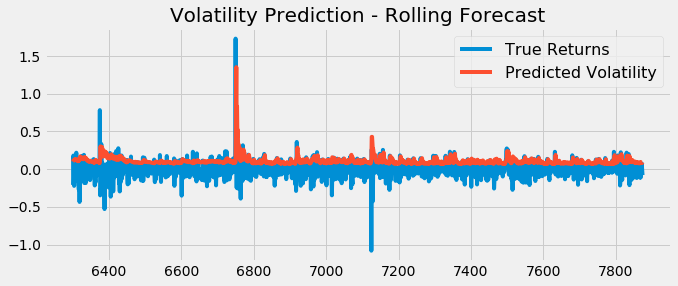

In [47]:
actual, pred = stock_analysis_arch('reliance.json')

In [34]:
def calculate_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    print('MAE: %f' % mae)
    
    mse = mean_squared_error(actual, pred)
    print('RMSE %f' % np.sqrt(mse))
    
    mask = actual != 0
    mape = (np.fabs(actual - pred)/np.fabs(actual))[mask].mean()
    print('MAPE %f' % mape)

In [35]:
calculate_metrics(actual, pred)

MAE: 0.120901
RMSE 0.159691
MAPE 4.343996
